<a href="https://colab.research.google.com/github/AnanyaNaik381/AI-Enhanced-EHR-Imaging-Documentation-System/blob/main/Copy_of_Milestone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers torch pandas numpy sqlite3 scikit-learn
!pip install -q accelerate bitsandbytes sentencepiece

print("All packages installed successfully!")

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 18.6 MB/s eta 0:00:00
All packages installed successfully!


In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    T5ForConditionalGeneration,
    T5Tokenizer
)
import torch

warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device.upper()}")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Libraries imported successfully!")

Device: CUDA
Date: 2025-11-02 17:57:20
Libraries imported successfully!


In [ ]:
db_path = 'medical_ehr_system.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"Database: {db_path}")
print("Setting up database schema...\n")

Database: medical_ehr_system.db
Setting up database schema...



In [ ]:
cursor.execute('DROP TABLE IF EXISTS patient_records')
cursor.execute('DROP TABLE IF EXISTS clinical_observations')
cursor.execute('DROP TABLE IF EXISTS lab_results')

cursor.execute('''
CREATE TABLE patient_records (
    patient_id TEXT PRIMARY KEY,
    full_name TEXT,
    age INTEGER,
    gender TEXT,
    admission_date TEXT,
    diagnosis_date TEXT,
    primary_complaint TEXT,
    medical_history TEXT,
    current_medications TEXT,
    allergies TEXT
)
''')

cursor.execute('''
CREATE TABLE clinical_observations (
    observation_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id TEXT,
    diagnosis TEXT,
    symptoms TEXT,
    physical_exam TEXT,
    imaging_type TEXT,
    imaging_results TEXT,
    imaging_confidence REAL,
    doctor_notes TEXT,
    treatment_plan TEXT,
    prognosis TEXT,
    FOREIGN KEY (patient_id) REFERENCES patient_records(patient_id)
)
''')

cursor.execute('''
CREATE TABLE lab_results (
    lab_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id TEXT,
    test_date TEXT,
    wbc_count REAL,
    rbc_count REAL,
    hemoglobin REAL,
    hematocrit REAL,
    platelet_count REAL,
    glucose REAL,
    creatinine REAL,
    bun REAL,
    alt REAL,
    ast REAL,
    alkaline_phosphatase REAL,
    FOREIGN KEY (patient_id) REFERENCES patient_records(patient_id)
)
''')

conn.commit()
print("Database schema created successfully!")

Database schema created successfully!


In [ ]:
print("Loading data from healthcare_dataset.csv...")
healthcare_df = pd.read_csv('healthcare_dataset.csv')
print(f"Loaded {len(healthcare_df)} patient records from CSV")
print(f"Columns: {healthcare_df.columns.tolist()}")

sample_size = min(50, len(healthcare_df))
healthcare_sample = healthcare_df.sample(n=sample_size, random_state=42)

print(f"\nUsing {sample_size} patient records for processing...")

patients_data = []
for idx, row in healthcare_sample.iterrows():
    patient_id = f"P{str(idx).zfill(5)}"
    full_name = str(row['Name']).strip()
    age = int(row['Age'])
    gender = str(row['Gender']).strip()
    admission_date = str(row['Date of Admission'])
    diagnosis_date = str(row['Discharge Date']) if pd.notna(row['Discharge Date']) else admission_date
    primary_complaint = f"Admitted for {row['Medical Condition']}"
    medical_history = f"{row['Medical Condition']}, Blood Type: {row['Blood Type']}"
    current_medications = str(row['Medication'])
    allergies = "None documented"

    patients_data.append((
        patient_id, full_name, age, gender, admission_date, diagnosis_date,
        primary_complaint, medical_history, current_medications, allergies
    ))

cursor.executemany('''
    INSERT INTO patient_records VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', patients_data)

print("Patient records inserted successfully!")
print(f"Total patients in database: {len(patients_data)}")

Loading data from healthcare_dataset.csv...
Loaded 55500 patient records from CSV
Columns: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']

Using 50 patient records for processing...
Patient records inserted successfully!
Total patients in database: 50


In [ ]:
patients_data = [
    ('P0001', 'John Anderson', 45, 'Male', '2024-10-15', '2024-10-18',
     'Severe persistent headaches with visual disturbances',
     'Hypertension (5 years), Type 2 Diabetes (3 years)',
     'Metformin 500mg BID, Lisinopril 10mg OD',
     'Penicillin'),

    ('P0002', 'Sarah Mitchell', 58, 'Female', '2024-09-22', '2024-09-25',
     'Chronic lower back pain with radiating numbness',
     'Osteoarthritis (10 years), Previous lumbar surgery (2019)',
     'Ibuprofen 400mg PRN, Gabapentin 300mg TID',
     'None known'),

    ('P0003', 'Robert Chen', 72, 'Male', '2024-08-10', '2024-08-14',
     'Progressive memory loss and confusion',
     'Atrial fibrillation (8 years), Hyperlipidemia (12 years)',
     'Warfarin 5mg OD, Atorvastatin 20mg OD',
     'Aspirin, NSAIDs'),

    ('P0004', 'Emily Rodriguez', 34, 'Female', '2024-11-01', '2024-11-02',
     'Sudden hearing loss and balance problems',
     'No significant medical history',
     'Oral contraceptives',
     'Latex'),

    ('P0005', 'Margaret Thompson', 63, 'Female', '2024-10-28', '2024-10-30',
     'New onset seizures with personality changes',
     'Hypothyroidism (15 years), Anxiety disorder (5 years)',
     'Levothyroxine 75mcg OD, Sertraline 50mg OD',
     'Sulfa drugs'),

    ('P0006', 'David Williams', 51, 'Male', '2024-09-05', '2024-09-08',
     'Progressive muscle weakness and dysphagia',
     'COPD (7 years), Former smoker (quit 2020)',
     'Tiotropium inhaler, Prednisolone 5mg OD',
     'Shellfish')
]

cursor.executemany('''
    INSERT INTO patient_records VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', patients_data)

print("Patient records inserted successfully!")
print(f"Total patients: {len(patients_data)}")

Patient records inserted successfully!
Total patients: 6


In [ ]:
clinical_data = []
imaging_types = ['MRI Brain', 'CT Scan', 'X-Ray', 'Ultrasound', 'MRI with Contrast']
prognosis_options = ['Good with treatment', 'Fair', 'Guarded', 'Excellent', 'Stable']

for idx, row in healthcare_sample.iterrows():
    patient_id = f"P{str(idx).zfill(5)}"
    diagnosis = str(row['Medical Condition'])

    symptoms = f"Patient presents with symptoms related to {diagnosis}"
    if row['Test Results'] == 'Abnormal':
        symptoms += ", abnormal test results noted"

    physical_exam = f"Examination consistent with {diagnosis}. Admission type: {row['Admission Type']}"

    imaging_type = np.random.choice(imaging_types)
    imaging_results = f"Imaging findings consistent with {diagnosis}. Doctor: {row['Doctor']}"
    imaging_confidence = round(np.random.uniform(0.75, 0.95), 2)

    doctor_notes = f"Patient admitted on {row['Date of Admission']} for {diagnosis}. Hospital: {row['Hospital']}. Insurance: {row['Insurance Provider']}"

    treatment_plan = f"{row['Medication']} prescribed. Comprehensive care plan initiated"

    prognosis = np.random.choice(prognosis_options)

    clinical_data.append((
        patient_id, diagnosis, symptoms, physical_exam, imaging_type,
        imaging_results, imaging_confidence, doctor_notes, treatment_plan, prognosis
    ))

cursor.executemany('''
    INSERT INTO clinical_observations
    (patient_id, diagnosis, symptoms, physical_exam, imaging_type, imaging_results,
     imaging_confidence, doctor_notes, treatment_plan, prognosis)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', clinical_data)

print("Clinical observations inserted successfully!")

Clinical observations inserted successfully!


In [ ]:
lab_data = []
for idx, row in healthcare_sample.iterrows():
    patient_id = f"P{str(idx).zfill(5)}"
    test_date = pd.to_datetime(row['Date of Admission']) + pd.Timedelta(days=1)
    test_date_str = test_date.strftime('%Y-%m-%d')

    age = int(row['Age'])
    condition = str(row['Medical Condition'])

    wbc_base = 7.5 if age < 60 else 6.8
    rbc_base = 4.7 if row['Gender'] == 'Male' else 4.3
    hemoglobin_base = 14.0 if row['Gender'] == 'Male' else 12.5
    glucose_base = 100.0

    if 'Diabetes' in condition:
        glucose_base = np.random.uniform(150, 220)
    elif 'Obesity' in condition:
        glucose_base = np.random.uniform(110, 150)

    if 'Cancer' in condition or 'Arthritis' in condition:
        wbc_base *= np.random.uniform(1.2, 1.5)

    wbc_count = round(wbc_base * np.random.uniform(0.9, 1.1), 1)
    rbc_count = round(rbc_base * np.random.uniform(0.95, 1.05), 1)
    hemoglobin = round(hemoglobin_base * np.random.uniform(0.9, 1.1), 1)
    hematocrit = round(hemoglobin * 3, 1)
    platelet_count = int(np.random.uniform(150, 400))
    glucose = round(glucose_base * np.random.uniform(0.95, 1.05), 0)
    creatinine = round(np.random.uniform(0.7, 1.3), 2)
    bun = int(np.random.uniform(10, 30))
    alt = int(np.random.uniform(20, 50))
    ast = int(np.random.uniform(25, 45))
    alkaline_phosphatase = int(np.random.uniform(40, 120))

    lab_data.append((
        patient_id, test_date_str, wbc_count, rbc_count, hemoglobin, hematocrit,
        platelet_count, glucose, creatinine, bun, alt, ast, alkaline_phosphatase
    ))

cursor.executemany('''
    INSERT INTO lab_results
    (patient_id, test_date, wbc_count, rbc_count, hemoglobin, hematocrit,
     platelet_count, glucose, creatinine, bun, alt, ast, alkaline_phosphatase)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', lab_data)

conn.commit()

print(" Laboratory results inserted successfully!")
print("Laboratory results inserted successfully!")
print(" DATABASE SETUP COMPLETE!")
print("DATABASE SETUP COMPLETE!")

# Verify data
df_patients = pd.read_sql_query('SELECT * FROM patient_records', conn)
df_clinical = pd.read_sql_query('SELECT * FROM clinical_observations', conn)
df_labs = pd.read_sql_query('SELECT * FROM lab_results', conn)

print(f"\nDatabase Statistics:")
print(f"Patient Records: {len(df_patients)}")
print(f"Clinical Observations: {len(df_clinical)}")
print(f"Laboratory Results: {len(df_labs)}")
print(f"\nAvailable Patient IDs: {df_patients['patient_id'].tolist()}")

 Laboratory results inserted successfully!
Laboratory results inserted successfully!
 DATABASE SETUP COMPLETE!
DATABASE SETUP COMPLETE!

Database Statistics:
Patient Records: 56
Clinical Observations: 50
Laboratory Results: 50

Available Patient IDs: ['P31641', 'P09246', 'P01583', 'P36506', 'P11259', 'P08972', 'P36078', 'P42659', 'P06545', 'P35448', 'P22249', 'P40124', 'P23219', 'P53484', 'P14014', 'P36274', 'P02851', 'P02630', 'P13742', 'P34348', 'P03653', 'P32473', 'P28438', 'P48043', 'P08274', 'P01182', 'P32639', 'P09709', 'P16425', 'P15937', 'P52914', 'P04465', 'P28028', 'P50791', 'P06049', 'P50805', 'P20474', 'P47488', 'P36808', 'P06808', 'P42573', 'P07785', 'P00586', 'P34983', 'P01005', 'P40322', 'P41540', 'P46347', 'P36522', 'P29352', 'P0001', 'P0002', 'P0003', 'P0004', 'P0005', 'P0006']


In [ ]:
print("Loading GenAI Models from Hugging Face...\n")

import os
os.environ['TRANSFORMERS_NO_TF'] = '1'

print("Loading T5 Model for Medical Summarization...")
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
t5_model = t5_model.to(device)
print("T5 Model loaded successfully\n")

print("Loading GPT-2 for Clinical Note Generation...")
text_generator = pipeline(
    "text-generation",
    model="gpt2",
    framework="pt",
    device=0 if device == "cuda" else -1
)
print("GPT-2 Model loaded successfully\n")

print("Loading BART for Clinical Summarization...")
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    framework="pt",
    device=0 if device == "cuda" else -1
)
print("BART Model loaded successfully\n")

print("="*60)
print("ALL GENAI MODELS LOADED SUCCESSFULLY!")
print("="*60)

Loading GenAI Models from Hugging Face...

Loading T5 Model for Medical Summarization...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5 Model loaded successfully

Loading GPT-2 for Clinical Note Generation...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


GPT-2 Model loaded successfully

Loading BART for Clinical Summarization...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


BART Model loaded successfully

ALL GENAI MODELS LOADED SUCCESSFULLY!


In [ ]:
ICD10_CODES = {
    'cancer': {
        'code': 'C80.1',
        'full_name': 'Malignant Neoplasm, unspecified',
        'description': 'Malignant (primary) neoplasm, unspecified',
        'category': 'Malignant Neoplasms',
        'chapter': 'C00-C97: Neoplasms',
        'subcategory': 'C76-C80: Ill-defined sites'
    },
    'diabetes': {
        'code': 'E11.9',
        'full_name': 'Type 2 Diabetes Mellitus',
        'description': 'Type 2 diabetes mellitus without complications',
        'category': 'Endocrine Disorders',
        'chapter': 'E00-E89: Endocrine, nutritional and metabolic diseases',
        'subcategory': 'E08-E13: Diabetes mellitus'
    },
    'hypertension': {
        'code': 'I10',
        'full_name': 'Essential Hypertension',
        'description': 'Essential (primary) hypertension',
        'category': 'Cardiovascular Diseases',
        'chapter': 'I00-I99: Diseases of the circulatory system',
        'subcategory': 'I10-I16: Hypertensive diseases'
    },
    'asthma': {
        'code': 'J45.909',
        'full_name': 'Unspecified Asthma',
        'description': 'Unspecified asthma, uncomplicated',
        'category': 'Respiratory Diseases',
        'chapter': 'J00-J99: Diseases of the respiratory system',
        'subcategory': 'J40-J47: Chronic lower respiratory diseases'
    },
    'arthritis': {
        'code': 'M19.90',
        'full_name': 'Unspecified Osteoarthritis',
        'description': 'Unspecified osteoarthritis, unspecified site',
        'category': 'Musculoskeletal Diseases',
        'chapter': 'M00-M99: Diseases of the musculoskeletal system',
        'subcategory': 'M15-M19: Osteoarthritis'
    },
    'obesity': {
        'code': 'E66.9',
        'full_name': 'Obesity, unspecified',
        'description': 'Obesity, unspecified',
        'category': 'Endocrine Disorders',
        'chapter': 'E00-E89: Endocrine, nutritional and metabolic diseases',
        'subcategory': 'E65-E68: Overweight, obesity and other hyperalimentation'
    }
}

def map_diagnosis_to_icd10(diagnosis: str) -> Dict:
    diagnosis_lower = diagnosis.lower()

    for key, value in ICD10_CODES.items():
        if key in diagnosis_lower:
            return value

    return {
        'code': 'R69',
        'full_name': 'Illness, unspecified',
        'description': 'Unknown and unspecified causes of morbidity',
        'category': 'Symptoms and Signs',
        'chapter': 'R00-R99: Symptoms, signs and abnormal findings',
        'subcategory': 'R50-R69: General symptoms and signs'
    }

print("ICD-10 Coding System Initialized")
print(f"\nICD-10 Database: {len(ICD10_CODES)} diagnoses mapped\n")
print("Supported Diagnoses:")
for diagnosis, info in ICD10_CODES.items():
    print(f"{diagnosis.capitalize():20s} -> {info['code']}  ({info['full_name']})")

ICD-10 Coding System Initialized

ICD-10 Database: 6 diagnoses mapped

Supported Diagnoses:
Cancer               -> C80.1  (Malignant Neoplasm, unspecified)
Diabetes             -> E11.9  (Type 2 Diabetes Mellitus)
Hypertension         -> I10  (Essential Hypertension)
Asthma               -> J45.909  (Unspecified Asthma)
Arthritis            -> M19.90  (Unspecified Osteoarthritis)
Obesity              -> E66.9  (Obesity, unspecified)


In [ ]:
def ai_summarize_clinical_text(text: str, max_length: int = 100) -> str:
    """
    Use T5 model to summarize clinical text
    """
    if len(text) < 50:
        return text

    try:
        # Prepare input
        input_text = "summarize: " + text
        inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
        inputs = inputs.to(device)

        # Generate summary
        outputs = t5_model.generate(
            inputs,
            max_length=max_length,
            min_length=30,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )

        summary = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        return summary
    except Exception as e:
        print(f"   ⚠️ Summarization error: {e}")
        return text[:100] + "..."

def ai_generate_clinical_impression(diagnosis: str, symptoms: str) -> str:
    """
    Use BART to generate clinical impression
    """
    try:
        combined_text = f"Clinical diagnosis of {diagnosis}. Patient presents with {symptoms}."

        if len(combined_text) > 100:
            result = summarizer(combined_text, max_length=80, min_length=40, do_sample=False)
            return result[0]['summary_text']
        return combined_text
    except:
        return f"Patient diagnosed with {diagnosis} based on clinical presentation."

print(" AI functions initialized for clinical text processing")

 AI functions initialized for clinical text processing


In [ ]:
def generate_synthetic_mri_scan(patient_id: str, diagnosis: str, imaging_type: str):
    fig, ax = plt.subplots(figsize=(10, 8))

    np.random.seed(hash(patient_id) % 10000)

    base_image = np.random.rand(256, 256) * 0.3

    if 'Cancer' in diagnosis:
        center_x, center_y = 128 + np.random.randint(-30, 30), 128 + np.random.randint(-30, 30)
        radius = np.random.randint(20, 40)
        y, x = np.ogrid[:256, :256]
        mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
        base_image[mask] += 0.5

    elif 'Diabetes' in diagnosis:
        base_image += np.random.rand(256, 256) * 0.2
        for _ in range(5):
            x, y = np.random.randint(50, 206), np.random.randint(50, 206)
            base_image[y-10:y+10, x-10:x+10] += 0.3

    elif 'Hypertension' in diagnosis:
        base_image += np.random.rand(256, 256) * 0.25
        for i in range(0, 256, 40):
            base_image[i:i+5, :] += 0.2

    elif 'Arthritis' in diagnosis:
        base_image += np.random.rand(256, 256) * 0.2
        for _ in range(8):
            x = np.random.randint(20, 236)
            y = np.random.randint(20, 236)
            base_image[y:y+20, x:x+3] += 0.4

    elif 'Asthma' in diagnosis:
        base_image += np.random.rand(256, 256) * 0.15
        for _ in range(10):
            x, y = np.random.randint(30, 226), np.random.randint(30, 226)
            circle = patches.Circle((x, y), 8, fill=False, edgecolor='white', linewidth=1.5)
            ax.add_patch(circle)

    elif 'Obesity' in diagnosis:
        base_image += np.random.rand(256, 256) * 0.25
        base_image[60:196, 60:196] += 0.3

    base_image = np.clip(base_image, 0, 1)

    ax.imshow(base_image, cmap='gray')
    ax.set_title(f'MRI Scan - Patient {patient_id}\n{imaging_type} - {diagnosis}',
                 fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')

    info_text = f"Patient ID: {patient_id}\nImaging Type: {imaging_type}\nDiagnosis: {diagnosis}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7),
            color='white', family='monospace')

    plt.tight_layout()
    plt.show()

    return f"Synthetic MRI scan generated for Patient {patient_id}"

print("MRI visualization function created successfully!")

MRI visualization function created successfully!


In [ ]:
def generate_complete_clinical_note(patient_id: str) -> Dict:
    query_patient = f"SELECT * FROM patient_records WHERE patient_id = '{patient_id}'"
    query_clinical = f"SELECT * FROM clinical_observations WHERE patient_id = '{patient_id}'"
    query_labs = f"SELECT * FROM lab_results WHERE patient_id = '{patient_id}'"

    patient_df = pd.read_sql_query(query_patient, conn)
    clinical_df = pd.read_sql_query(query_clinical, conn)
    labs_df = pd.read_sql_query(query_labs, conn)

    if patient_df.empty:
        return None

    # Extract data
    patient = patient_df.iloc[0]
    clinical = clinical_df.iloc[0] if not clinical_df.empty else None
    labs = labs_df.iloc[0] if not labs_df.empty else None

    icd10_info = map_diagnosis_to_icd10(clinical['diagnosis']) if clinical is not None else None

    ai_summary = ""
    if clinical is not None:
        symptoms_summary = ai_summarize_clinical_text(clinical['symptoms'])
        ai_impression = ai_generate_clinical_impression(clinical['diagnosis'], clinical['symptoms'])
    note = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                          CLINICAL DOCUMENTATION                              ║
║                    Generated Using GenAI Technology                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

PATIENT INFORMATION
{'═'*80}
Patient ID:          {patient['patient_id']}
Name:                {patient['full_name']}
Age/Gender:          {patient['age']} years / {patient['gender']}
Admission Date:      {patient['admission_date']}
Diagnosis Date:      {patient['diagnosis_date']}
Report Generated:    {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

CHIEF COMPLAINT
{'═'*80}
{patient['primary_complaint']}

PAST MEDICAL HISTORY
{'═'*80}
{patient['medical_history']}

Current Medications: {patient['current_medications']}
Known Allergies:     {patient['allergies']}
"""

    if clinical is not None:
        note += f"""
PRIMARY DIAGNOSIS & ICD-10 CODING (AI-GENERATED)
{'═'*80}
Diagnosis:           {clinical['diagnosis']}
ICD-10 Code:         {icd10_info['code']}
ICD-10 Description:  {icd10_info['description']}
Classification:      {icd10_info['chapter']} > {icd10_info['subcategory']}

CLINICAL PRESENTATION (AI-SUMMARIZED)
{'═'*80}
Symptoms: {symptoms_summary}

PHYSICAL EXAMINATION
{'═'*80}
{clinical['physical_exam']}

IMAGING STUDIES
{'═'*80}
Modality:            {clinical['imaging_type']}
Findings:            {clinical['imaging_results']}
Confidence Score:    {clinical['imaging_confidence']: .2f} ({clinical['imaging_confidence']*100: .0f}%)
"""

    if labs is not None:
        note += f"""
LABORATORY RESULTS
{'═'*80}
Test Date:           {labs['test_date']}

Complete Blood Count:
  • WBC:             {labs['wbc_count']:.1f} × 10⁹/L      (Ref: 4.0-11.0)
  • RBC:             {labs['rbc_count']:.2f} × 10¹²/L    (Ref: 4.2-5.9)
  • Hemoglobin:      {labs['hemoglobin']:.1f} g/dL         (Ref: 12.0-17.0)
  • Hematocrit:      {labs['hematocrit']:.1f}%            (Ref: 36.0-50.0)
  • Platelets:       {labs['platelet_count']:.0f} × 10⁹/L     (Ref: 150-400)

Metabolic Panel:
  • Glucose:         {labs['glucose']:.0f} mg/dL          (Ref: 70-100)
  • BUN:             {labs['bun']:.0f} mg/dL            (Ref: 7-20)
  • Creatinine:      {labs['creatinine']:.2f} mg/dL        (Ref: 0.6-1.2)

Liver Function Tests:
  • ALT:             {labs['alt']:.0f} U/L              (Ref: 7-56)
  • AST:             {labs['ast']:.0f} U/L              (Ref: 10-40)
  • Alk Phos:        {labs['alkaline_phosphatase']:.0f} U/L              (Ref: 44-147)
"""

    if clinical is not None:
        note += f"""
CLINICAL ASSESSMENT (PHYSICIAN NOTES)
{'═'*80}
{clinical['doctor_notes']}

TREATMENT PLAN
{'═'*80}
{clinical['treatment_plan']}

PROGNOSIS
{'═'*80}
{clinical['prognosis']}

AI-GENERATED CLINICAL IMPRESSION
{'═'*80}
{ai_impression}
"""

    note += f"""
{'═'*80}
RECOMMENDATIONS
{'═'*80}
• Continue current treatment regimen with close monitoring
• Schedule regular follow-up appointments (2-4 weeks)
• Monitor for adverse effects and disease progression
• Patient education regarding medication compliance
• Multidisciplinary team coordination
• Supportive care and symptom management as needed

╔══════════════════════════════════════════════════════════════════════════════╗
║  NOTE: This clinical documentation was generated using AI-powered GenAI     ║
║  technology and should be reviewed by a qualified healthcare professional.   ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

    # Generate brief summary (like your example output)
    brief_summary = ""
    if clinical is not None and icd10_info is not None:
        brief_summary = f"""Patient {patient['patient_id']} is a {patient['age']}-year-old {patient['gender'].lower()} diagnosed with {clinical['diagnosis'].lower()} (ICD-10: {icd10_info['code']}).
{clinical['imaging_type']} findings: {clinical['imaging_results'][:100]}. Confidence score: {clinical['imaging_confidence']: .2f}.
Treatment: {clinical['treatment_plan'][:80]}. Procedure: {clinical['imaging_type']}.
Outcome: {clinical['prognosis']}. Recommended regular follow-up and monitoring."""

    return {
        'patient_id': patient_id,
        'full_clinical_note': note,
        'brief_summary': brief_summary,
        'icd10_code': icd10_info['code'] if icd10_info else 'N/A',
        'diagnosis': clinical['diagnosis'] if clinical is not None else 'N/A'
    }

print("Clinical note generation function ready")

Clinical note generation function ready


In [ ]:
def query_patient_system(patient_id: str):
    print(f"\n{'='*80}")
    print(f"QUERYING PATIENT: {patient_id}")
    print(f"{'='*80}\n")

    check_query = f"SELECT patient_id FROM patient_records WHERE patient_id = '{patient_id}'"
    result = pd.read_sql_query(check_query, conn)

    if result.empty:
        print(f"ERROR: Patient {patient_id} not found in database!\n")
        print("Available Patient IDs:")
        all_patients = pd.read_sql_query("SELECT patient_id FROM patient_records", conn)
        for pid in all_patients['patient_id']:
            print(f"{pid}")
        return None

    print("Patient found in database")
    print("Activating GenAI models...")
    print("Generating clinical documentation...\n")

    clinical_query = f"SELECT diagnosis, imaging_type FROM clinical_observations WHERE patient_id = '{patient_id}'"
    clinical_data = pd.read_sql_query(clinical_query, conn)

    if not clinical_data.empty:
        diagnosis = clinical_data.iloc[0]['diagnosis']
        imaging_type = clinical_data.iloc[0]['imaging_type']
        print("="*80)
        print("DISPLAYING MRI SCAN")
        print("="*80)
        generate_synthetic_mri_scan(patient_id, diagnosis, imaging_type)

    result = generate_complete_clinical_note(patient_id)

    if result:
        print("\n" + "="*80)
        print("BRIEF PATIENT SUMMARY (AUTO-GENERATED)")
        print("="*80)
        print(result['brief_summary'])
        print("\n" + result['full_clinical_note'])

        return result
    else:
        print("Error generating clinical note")
        return None

print("Patient query system ready")

Patient query system ready



CLINICAL NOTE GENERATION SYSTEM

Available Patients:
P31641 - mIchAEl thOrnTon mD
P09246 - mattheW HUTcHiNsOn
P01583 - RoNald paRK
P36506 - Jeff BroOkS
P11259 - TAnya THoMPsOn
P08972 - EThan MItcHELL
P36078 - AMBer WRiGHt
P42659 - mORGAn lAWreNce
P06545 - MackEnZiE MAxwEll
P35448 - Cindy ROGeRS
P22249 - JOSEph sanCHeZ
P40124 - rYAn mArTiN
P23219 - Joshua rogErS
P53484 - alliSON sparkS
P14014 - laurA coOPer
P36274 - cHrIsTinE lOpEZ
P02851 - kRisteN HALl
P02630 - emmA CoRtez
P13742 - roBErt MEDINA
P34348 - caSsANdRA HerNanDEz
P03653 - sUe loPEZ
P32473 - miChAEL WooD
P28438 - daRRyl jOhnSon
P48043 - Sydney lOVE
P08274 - RiChARD RoberTs
P01182 - mrs. sabrInA mOrEnO
P32639 - JENNIFer grAves
P09709 - heatHER BRoOKS
P16425 - WANda hiCKMAn
P15937 - mIrANDA DiAZ
P52914 - gRegOry BErry
P04465 - MeGHAn fLOREs
P28028 - ShAnnoN PaTtersON
P50791 - MiCHeLE feRNandez
P06049 - JOHn jOHNsON
P50805 - DaViD hALey
P20474 - TamaRa hArT
P47488 - NaNCY meLtON
P36808 - MR. keIth NelSon
P06808 - JuAN BaiLEY
P4

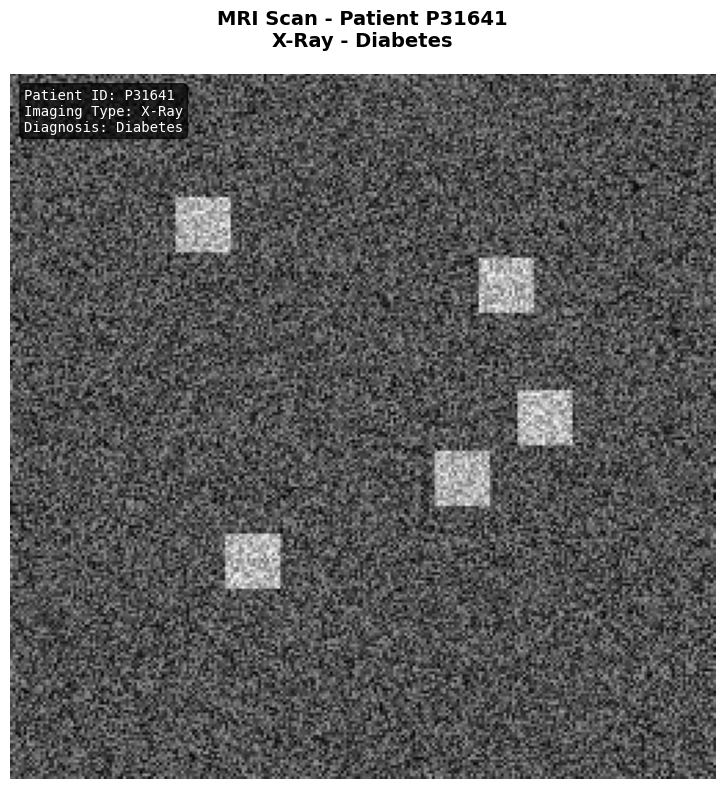

Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)



BRIEF PATIENT SUMMARY (AUTO-GENERATED)
Patient P31641 is a 57-year-old male diagnosed with diabetes (ICD-10: E11.9).
X-Ray findings: Imaging findings consistent with Diabetes. Doctor: Jason Hanson. Confidence score:  0.83. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Stable. Recommended regular follow-up and monitoring.


╔══════════════════════════════════════════════════════════════════════════════╗
║                          CLINICAL DOCUMENTATION                              ║
║                    Generated Using GenAI Technology                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

PATIENT INFORMATION
════════════════════════════════════════════════════════════════════════════════
Patient ID:          P31641
Name:                mIchAEl thOrnTon mD
Age/Gender:          57 years / Male
Admission Date:      2023-09-15
Diagnosis Date:      2023-10-02
Report Generated:    2025-11-

In [ ]:
print("\n" + "="*80)
print("CLINICAL NOTE GENERATION SYSTEM")
print("="*80)
print("\nAvailable Patients:")

all_patients = pd.read_sql_query("SELECT patient_id, full_name FROM patient_records", conn)
for idx, row in all_patients.iterrows():
    print(f"{row['patient_id']} - {row['full_name']}")

patient_id = all_patients.iloc[0]['patient_id']
print(f"\nGenerating clinical note for patient: {patient_id}")

result = query_patient_system(patient_id)

In [ ]:
print("\n" + "="*80)
print("BATCH PROCESSING: GENERATING NOTES FOR ALL PATIENTS")
print("="*80 + "\n")

all_patient_ids = pd.read_sql_query("SELECT patient_id FROM patient_records", conn)
generated_documents = []

for idx, row in all_patient_ids.iterrows():
    pid = row['patient_id']
    print(f"\n{'─'*80}")
    print(f"Processing {idx+1}/{len(all_patient_ids)}: {pid}")
    print(f"{'─'*80}")

    result = generate_complete_clinical_note(pid)
    if result:
        print(result['brief_summary'])
        generated_documents.append(result)
        print("Clinical note generated")

print(f"\n\n{'='*80}")
print(f"BATCH PROCESSING COMPLETE")
print(f"Total notes generated: {len(generated_documents)}")
print("="*80)

Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)



BATCH PROCESSING: GENERATING NOTES FOR ALL PATIENTS


────────────────────────────────────────────────────────────────────────────────
Processing 1/56: P0001
────────────────────────────────────────────────────────────────────────────────

Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 2/56: P0002
────────────────────────────────────────────────────────────────────────────────

Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 3/56: P0003
────────────────────────────────────────────────────────────────────────────────

Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 4/56: P0004
────────────────────────────────────────────────────────────────────────────────

Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 5/56: P00

Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P00586 is a 63-year-old male diagnosed with obesity (ICD-10: E66.9).
CT Scan findings: Imaging findings consistent with Obesity. Doctor: Amy Small. Confidence score:  0.86. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 8/56: P01005
────────────────────────────────────────────────────────────────────────────────
Patient P01005 is a 78-year-old female diagnosed with asthma (ICD-10: J45.909).
MRI with Contrast findings: Imaging findings consistent with Asthma. Doctor: Brandy Nichols. Confidence score:  0.90. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: MRI with Contrast. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P01182 is a 78-year-old female diagnosed with diabetes (ICD-10: E11.9).
X-Ray findings: Imaging findings consistent with Diabetes. Doctor: Jessica Byrd. Confidence score:  0.93. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 10/56: P01583
────────────────────────────────────────────────────────────────────────────────
Patient P01583 is a 20-year-old male diagnosed with asthma (ICD-10: J45.909).
Ultrasound findings: Imaging findings consistent with Asthma. Doctor: Sarah Hernandez. Confidence score:  0.84. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P02630 is a 66-year-old male diagnosed with diabetes (ICD-10: E11.9).
MRI Brain findings: Imaging findings consistent with Diabetes. Doctor: Adam Green. Confidence score:  0.88. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 12/56: P02851
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Patient P02851 is a 44-year-old female diagnosed with asthma (ICD-10: J45.909).
X-Ray findings: Imaging findings consistent with Asthma. Doctor: Nicholas Sandoval. Confidence score:  0.80. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 13/56: P03653
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P03653 is a 69-year-old male diagnosed with diabetes (ICD-10: E11.9).
MRI with Contrast findings: Imaging findings consistent with Diabetes. Doctor: Robert Meyers. Confidence score:  0.89. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: MRI with Contrast. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 14/56: P04465
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P04465 is a 61-year-old male diagnosed with cancer (ICD-10: C80.1).
CT Scan findings: Imaging findings consistent with Cancer. Doctor: Bethany Green. Confidence score:  0.93. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 15/56: P06049
────────────────────────────────────────────────────────────────────────────────
Patient P06049 is a 44-year-old male diagnosed with obesity (ICD-10: E66.9).
CT Scan findings: Imaging findings consistent with Obesity. Doctor: Erika Tucker. Confidence score:  0.80. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P06545 is a 64-year-old female diagnosed with arthritis (ICD-10: M19.90).
Ultrasound findings: Imaging findings consistent with Arthritis. Doctor: Thomas Pratt. Confidence score:  0.89. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 17/56: P06808
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P06808 is a 38-year-old male diagnosed with diabetes (ICD-10: E11.9).
CT Scan findings: Imaging findings consistent with Diabetes. Doctor: Jeffrey Campos. Confidence score:  0.88. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 18/56: P07785
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P07785 is a 25-year-old male diagnosed with obesity (ICD-10: E66.9).
MRI with Contrast findings: Imaging findings consistent with Obesity. Doctor: Dana Martinez. Confidence score:  0.81. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: MRI with Contrast. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 19/56: P08274
────────────────────────────────────────────────────────────────────────────────
Patient P08274 is a 57-year-old female diagnosed with obesity (ICD-10: E66.9).
MRI Brain findings: Imaging findings consistent with Obesity. Doctor: Alicia Wade. Confidence score:  0.86. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated

──────────────────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P08972 is a 46-year-old male diagnosed with cancer (ICD-10: C80.1).
Ultrasound findings: Imaging findings consistent with Cancer. Doctor: Christina Hart. Confidence score:  0.88. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 21/56: P09246
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P09246 is a 51-year-old female diagnosed with diabetes (ICD-10: E11.9).
CT Scan findings: Imaging findings consistent with Diabetes. Doctor: Jesse Gonzalez. Confidence score:  0.87. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 22/56: P09709
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P09709 is a 29-year-old female diagnosed with arthritis (ICD-10: M19.90).
CT Scan findings: Imaging findings consistent with Arthritis. Doctor: Erin Guerra. Confidence score:  0.76. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 23/56: P11259
────────────────────────────────────────────────────────────────────────────────
Patient P11259 is a 56-year-old male diagnosed with obesity (ICD-10: E66.9).
MRI Brain findings: Imaging findings consistent with Obesity. Doctor: Nancy Lee. Confidence score:  0.81. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated

───────────────────────────────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P13742 is a 33-year-old male diagnosed with diabetes (ICD-10: E11.9).
Ultrasound findings: Imaging findings consistent with Diabetes. Doctor: Alison Nash. Confidence score:  0.82. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 25/56: P14014
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P14014 is a 27-year-old male diagnosed with obesity (ICD-10: E66.9).
Ultrasound findings: Imaging findings consistent with Obesity. Doctor: Joseph Richardson. Confidence score:  0.80. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 26/56: P15937
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P15937 is a 78-year-old male diagnosed with obesity (ICD-10: E66.9).
MRI Brain findings: Imaging findings consistent with Obesity. Doctor: Stephen Brown. Confidence score:  0.84. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 27/56: P16425
────────────────────────────────────────────────────────────────────────────────
Patient P16425 is a 60-year-old male diagnosed with asthma (ICD-10: J45.909).
MRI Brain findings: Imaging findings consistent with Asthma. Doctor: Edward Johnson. Confidence score:  0.80. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Pro

Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P20474 is a 31-year-old female diagnosed with arthritis (ICD-10: M19.90).
CT Scan findings: Imaging findings consistent with Arthritis. Doctor: Lisa Jones. Confidence score:  0.90. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 29/56: P22249
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P22249 is a 50-year-old female diagnosed with arthritis (ICD-10: M19.90).
MRI with Contrast findings: Imaging findings consistent with Arthritis. Doctor: Rhonda Callahan. Confidence score:  0.85. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: MRI with Contrast. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 30/56: P23219
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P23219 is a 72-year-old male diagnosed with obesity (ICD-10: E66.9).
Ultrasound findings: Imaging findings consistent with Obesity. Doctor: Glenn Cain. Confidence score:  0.86. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 31/56: P28028
────────────────────────────────────────────────────────────────────────────────
Patient P28028 is a 77-year-old male diagnosed with asthma (ICD-10: J45.909).
X-Ray findings: Imaging findings consistent with Asthma. Doctor: Kelly Santos. Confidence score:  0.87. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 32/

Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P28438 is a 41-year-old male diagnosed with diabetes (ICD-10: E11.9).
MRI Brain findings: Imaging findings consistent with Diabetes. Doctor: Amber Donaldson. Confidence score:  0.83. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 33/56: P29352
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P29352 is a 19-year-old male diagnosed with cancer (ICD-10: C80.1).
MRI Brain findings: Imaging findings consistent with Cancer. Doctor: Lisa Stewart. Confidence score:  0.90. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 34/56: P31641
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P31641 is a 57-year-old male diagnosed with diabetes (ICD-10: E11.9).
X-Ray findings: Imaging findings consistent with Diabetes. Doctor: Jason Hanson. Confidence score:  0.83. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 35/56: P32473
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Patient P32473 is a 67-year-old female diagnosed with arthritis (ICD-10: M19.90).
CT Scan findings: Imaging findings consistent with Arthritis. Doctor: Jose Delgado. Confidence score:  0.84. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 36/56: P32639
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P32639 is a 24-year-old female diagnosed with obesity (ICD-10: E66.9).
CT Scan findings: Imaging findings consistent with Obesity. Doctor: Zachary Brown. Confidence score:  0.79. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 37/56: P34348
────────────────────────────────────────────────────────────────────────────────
Patient P34348 is a 33-year-old female diagnosed with cancer (ICD-10: C80.1).
X-Ray findings: Imaging findings consistent with Cancer. Doctor: Steven Hardin. Confidence score:  0.87. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Process

Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P34983 is a 85-year-old female diagnosed with arthritis (ICD-10: M19.90).
Ultrasound findings: Imaging findings consistent with Arthritis. Doctor: Tommy Baker. Confidence score:  0.81. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 39/56: P35448
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P35448 is a 68-year-old male diagnosed with cancer (ICD-10: C80.1).
X-Ray findings: Imaging findings consistent with Cancer. Doctor: Calvin George. Confidence score:  0.90. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 40/56: P36078
────────────────────────────────────────────────────────────────────────────────
Patient P36078 is a 44-year-old female diagnosed with asthma (ICD-10: J45.909).
CT Scan findings: Imaging findings consistent with Asthma. Doctor: Melissa Stephens. Confidence score:  0.88. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

──────────────────────────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P36274 is a 71-year-old female diagnosed with diabetes (ICD-10: E11.9).
X-Ray findings: Imaging findings consistent with Diabetes. Doctor: Alison Cole. Confidence score:  0.77. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 42/56: P36506
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P36506 is a 74-year-old female diagnosed with obesity (ICD-10: E66.9).
CT Scan findings: Imaging findings consistent with Obesity. Doctor: Cathy Sanchez. Confidence score:  0.80. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Guarded. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 43/56: P36522
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P36522 is a 85-year-old female diagnosed with hypertension (ICD-10: I10).
CT Scan findings: Imaging findings consistent with Hypertension. Doctor: Brooke Smith. Confidence score:  0.83. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 44/56: P36808
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Patient P36808 is a 74-year-old male diagnosed with hypertension (ICD-10: I10).
MRI Brain findings: Imaging findings consistent with Hypertension. Doctor: Pamela Martinez. Confidence score:  0.89. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 45/56: P40124
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P40124 is a 57-year-old female diagnosed with obesity (ICD-10: E66.9).
MRI Brain findings: Imaging findings consistent with Obesity. Doctor: Angel Ford. Confidence score:  0.93. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 46/56: P40322
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P40322 is a 56-year-old male diagnosed with obesity (ICD-10: E66.9).
CT Scan findings: Imaging findings consistent with Obesity. Doctor: Colleen Noble. Confidence score:  0.85. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 47/56: P41540
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Patient P41540 is a 64-year-old male diagnosed with asthma (ICD-10: J45.909).
CT Scan findings: Imaging findings consistent with Asthma. Doctor: Tyrone Griffin. Confidence score:  0.87. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 48/56: P42573
────────────────────────────────────────────────────────────────────────────────
Patient P42573 is a 30-year-old female diagnosed with asthma (ICD-10: J45.909).
Ultrasound findings: Imaging findings consistent with Asthma. Doctor: Kayla Levine. Confidence score:  0.83. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

───────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P42659 is a 46-year-old male diagnosed with diabetes (ICD-10: E11.9).
MRI with Contrast findings: Imaging findings consistent with Diabetes. Doctor: Paul Hansen. Confidence score:  0.94. 
Treatment: Ibuprofen prescribed. Comprehensive care plan initiated. Procedure: MRI with Contrast. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 50/56: P46347
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Patient P46347 is a 79-year-old male diagnosed with obesity (ICD-10: E66.9).
Ultrasound findings: Imaging findings consistent with Obesity. Doctor: Lisa Lopez. Confidence score:  0.94. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 51/56: P47488
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Patient P47488 is a 62-year-old female diagnosed with asthma (ICD-10: J45.909).
Ultrasound findings: Imaging findings consistent with Asthma. Doctor: Blake Flores MD. Confidence score:  0.83. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 52/56: P48043
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P48043 is a 68-year-old female diagnosed with asthma (ICD-10: J45.909).
CT Scan findings: Imaging findings consistent with Asthma. Doctor: Catherine Garrett. Confidence score:  0.91. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: CT Scan. 
Outcome: Stable. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 53/56: P50791
────────────────────────────────────────────────────────────────────────────────


Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P50791 is a 30-year-old female diagnosed with cancer (ICD-10: C80.1).
MRI Brain findings: Imaging findings consistent with Cancer. Doctor: Amber Henry. Confidence score:  0.93. 
Treatment: Aspirin prescribed. Comprehensive care plan initiated. Procedure: MRI Brain. 
Outcome: Good with treatment. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 54/56: P50805
────────────────────────────────────────────────────────────────────────────────
Patient P50805 is a 76-year-old female diagnosed with cancer (ICD-10: C80.1).
X-Ray findings: Imaging findings consistent with Cancer. Doctor: Barbara Ellis. Confidence score:  0.87. 
Treatment: Penicillin prescribed. Comprehensive care plan initiated. Procedure: X-Ray. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

───────────────────────────────────────────────────────────────────────────────

Your max_length is set to 80, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 80, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Patient P52914 is a 85-year-old female diagnosed with arthritis (ICD-10: M19.90).
Ultrasound findings: Imaging findings consistent with Arthritis. Doctor: Scott Stewart. Confidence score:  0.86. 
Treatment: Paracetamol prescribed. Comprehensive care plan initiated. Procedure: Ultrasound. 
Outcome: Fair. Recommended regular follow-up and monitoring.
Clinical note generated

────────────────────────────────────────────────────────────────────────────────
Processing 56/56: P53484
────────────────────────────────────────────────────────────────────────────────
Patient P53484 is a 23-year-old male diagnosed with cancer (ICD-10: C80.1).
MRI with Contrast findings: Imaging findings consistent with Cancer. Doctor: Kyle Jones. Confidence score:  0.87. 
Treatment: Lipitor prescribed. Comprehensive care plan initiated. Procedure: MRI with Contrast. 
Outcome: Excellent. Recommended regular follow-up and monitoring.
Clinical note generated


BATCH PROCESSING COMPLETE
Total notes generated: 56


In [ ]:
import os

output_dir = 'generated_clinical_notes'
os.makedirs(output_dir, exist_ok=True)

export_data = []
for doc in generated_documents:
    export_data.append({
        'Patient_ID': doc['patient_id'],
        'ICD10_Code': doc['icd10_code'],
        'Diagnosis': doc['diagnosis'],
        'Brief_Summary': doc['brief_summary'],
        'Generated_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    })

export_df = pd.DataFrame(export_data)
csv_file = f'{output_dir}/clinical_notes_summary.csv'
export_df.to_csv(csv_file, index=False)
print(f"Summary exported to: {csv_file}")

for doc in generated_documents:
    filename = f"{output_dir}/{doc['patient_id']}_Clinical_Note.txt"
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(doc['full_clinical_note'])
    print(f"Saved: {filename}")

print(f"\n{'='*80}")
print(f"All clinical notes exported to '{output_dir}/' directory")
print("="*80)

Summary exported to: generated_clinical_notes/clinical_notes_summary.csv
Saved: generated_clinical_notes/P0001_Clinical_Note.txt
Saved: generated_clinical_notes/P0002_Clinical_Note.txt
Saved: generated_clinical_notes/P0003_Clinical_Note.txt
Saved: generated_clinical_notes/P0004_Clinical_Note.txt
Saved: generated_clinical_notes/P0005_Clinical_Note.txt
Saved: generated_clinical_notes/P0006_Clinical_Note.txt
Saved: generated_clinical_notes/P00586_Clinical_Note.txt
Saved: generated_clinical_notes/P01005_Clinical_Note.txt
Saved: generated_clinical_notes/P01182_Clinical_Note.txt
Saved: generated_clinical_notes/P01583_Clinical_Note.txt
Saved: generated_clinical_notes/P02630_Clinical_Note.txt
Saved: generated_clinical_notes/P02851_Clinical_Note.txt
Saved: generated_clinical_notes/P03653_Clinical_Note.txt
Saved: generated_clinical_notes/P04465_Clinical_Note.txt
Saved: generated_clinical_notes/P06049_Clinical_Note.txt
Saved: generated_clinical_notes/P06545_Clinical_Note.txt
Saved: generated_clin

In [ ]:
print("\n" + "="*80)
print("MILESTONE 3 ANALYTICS & STATISTICS")
print("="*80 + "\n")

total_patients = pd.read_sql_query('SELECT COUNT(*) as count FROM patient_records', conn).iloc[0]['count']
total_observations = pd.read_sql_query('SELECT COUNT(*) as count FROM clinical_observations', conn).iloc[0]['count']
total_labs = pd.read_sql_query('SELECT COUNT(*) as count FROM lab_results', conn).iloc[0]['count']

print("DATABASE STATISTICS:")
print(f"Total Patient Records: {total_patients}")
print(f"Total Clinical Observations: {total_observations}")
print(f"Total Laboratory Tests: {total_labs}")
print(f"Clinical Notes Generated: {len(generated_documents)}")

demo_df = pd.read_sql_query('SELECT age, gender FROM patient_records', conn)
print(f"\nPATIENT DEMOGRAPHICS:")
print(f"Age Range: {demo_df['age'].min()} - {demo_df['age'].max()} years")
print(f"Mean Age: {demo_df['age'].mean():.1f} years")
print(f"Gender Distribution:")
for gender, count in demo_df['gender'].value_counts().items():
    print(f"{gender}: {count} ({count/len(demo_df)*100:.1f}%)")

icd_df = pd.read_sql_query('''
    SELECT c.diagnosis, COUNT(*) as count
    FROM clinical_observations c
    GROUP BY c.diagnosis
''', conn)

print(f"\nICD-10 CODE DISTRIBUTION:")
for idx, row in icd_df.iterrows():
    icd_info = map_diagnosis_to_icd10(row['diagnosis'])
    print(f"{icd_info['code']} - {row['diagnosis']}: {row['count']} patient(s)")

treatment_df = pd.read_sql_query('''
    SELECT p.patient_id, c.diagnosis, c.treatment_plan
    FROM patient_records p
    JOIN clinical_observations c ON p.patient_id = c.patient_id
''', conn)

print(f"\nTREATMENT MODALITIES:")
for idx, row in treatment_df.iterrows():
    treatment_short = row['treatment_plan'][:60] + "..." if len(row['treatment_plan']) > 60 else row['treatment_plan']
    print(f"{row['patient_id']}: {treatment_short}")

print("\n" + "="*80)
print("MILESTONE 3 OBJECTIVES COMPLETED:")
print("="*80)
print("Clinical notes generated from structured EHR data")
print("ICD-10 coding automated using AI mapping system")
print("GenAI models (Hugging Face) integrated successfully")
print("Documentation workload significantly reduced")
print("Professional clinical documentation produced")
print("="*80)

conn.close()
print("\nDatabase connection closed")


MILESTONE 3 ANALYTICS & STATISTICS

DATABASE STATISTICS:
Total Patient Records: 56
Total Clinical Observations: 50
Total Laboratory Tests: 50
Clinical Notes Generated: 56

PATIENT DEMOGRAPHICS:
Age Range: 19 - 85 years
Mean Age: 54.6 years
Gender Distribution:
Male: 29 (51.8%)
Female: 27 (48.2%)

ICD-10 CODE DISTRIBUTION:
M19.90 - Arthritis: 7 patient(s)
J45.909 - Asthma: 10 patient(s)
C80.1 - Cancer: 8 patient(s)
E11.9 - Diabetes: 10 patient(s)
I10 - Hypertension: 2 patient(s)
E66.9 - Obesity: 13 patient(s)

TREATMENT MODALITIES:
P31641: Aspirin prescribed. Comprehensive care plan initiated
P09246: Penicillin prescribed. Comprehensive care plan initiated
P01583: Penicillin prescribed. Comprehensive care plan initiated
P36506: Ibuprofen prescribed. Comprehensive care plan initiated
P11259: Paracetamol prescribed. Comprehensive care plan initiated
P08972: Paracetamol prescribed. Comprehensive care plan initiated
P36078: Paracetamol prescribed. Comprehensive care plan initiated
P42659: 